# Bayesian Updating with Conjugate Priors

When the data consists of binary Bernoulli random variables with a certain success probability for a positive outcome, the number of successes in repeated trials follows a Binomial distribution. The conjugate prior is the Beta distribution with support over the interval [0, 1] and two shape parameters to model arbitrary prior distributions over the success probability. Hence, the posterior distribution is also a Beta distribution that we can derive by directly updating the parameters.

## Setup

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib.ticker import FuncFormatter

In [3]:
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']

In [4]:
np.random.seed(42)
sns.set_style('dark')

## Formatting Helper

In [18]:
def format_plot(axes, i, p, y, trials, success, true_p, tmle, tmap=None):
    fmt = FuncFormatter(lambda x, _: f'{x:.0%}')
    if i >= 6:
#         axes[i].set_xlabel("$p$, Success Probability")
        axes[i].xaxis.set_major_formatter(fmt)
    else:
        axes[i].axes.get_xaxis().set_visible(False)
    if i % 3 == 0:
        axes[i].set_ylabel("Posterior Probability")
    axes[i].set_yticks([], [])

    axes[i].plot(p, y, lw=1, c='k')
    axes[i].fill_between(p, y, color='darkblue', alpha=0.4)
    axes[i].vlines(true_p, 0, max(10, np.max(y)), color='k', linestyle='--', lw=1)
    axes[i].set_title(f'Trials: {trials:,d} - Success: {success:,d}')
    if i > 0:
#         smle = r"$\theta_{{\mathrm{{MLE}}}}$ = {:.2%}".format(tmle)
        axes[i].text(x=.02, y=.85, transform=axes[i].transAxes)
#         smap = r"$\theta_{{\mathrm{{MAP}}}}$ = {:.2%}".format(tmap)
        axes[i].text(x=.02, y=.75, transform=axes[i].transAxes)    
    return axes[i]

## Simulate Coin Tosses & Updates of Posterior

In [19]:
n_trials = [0, 1, 3, 5, 10, 25, 50, 100, 500]
outcomes = stats.bernoulli.rvs(p=0.5, size=n_trials[-1])
p = np.linspace(0, 1, 100)
# uniform (uninformative) prior
a = b = 1

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 7), sharex=True)
axes = axes.flatten()
fmt = FuncFormatter(lambda x, _: f'{x:.0%}')
for i, trials in enumerate(n_trials):
    successes = outcomes[:trials]
    theta_mle = np.mean(successes)
    heads = sum(successes)
    tails = trials - heads
    update = stats.beta.pdf(p, a + heads , b + tails)
    theta_map = pd.Series(update, index=p).idxmax()
    axes[i] = format_plot(axes, i, p, update, trials=trials, success=heads, 
                          true_p=.5, tmle=theta_mle, tmap=theta_map)

title = 'Bayesian Probabilities: Updating the Posterior'
fig.suptitle(title,  y=1.02, fontsize=14)
fig.tight_layout()

TypeError: text() missing 1 required positional argument: 's'

RuntimeError: Failed to process string with tex because latex could not be found

<Figure size 1008x504 with 9 Axes>

## Stock Price Moves

We will collect samples of different sizes of binarized daily S&P 500 returns where the positive outcome is a price increase. Starting from an uninformative prior that allocates equal probability to each possible success probability in the interval [0, 1], we compute the posterior for different evidence samples. 

In [22]:
sp500_returns = pd.read_hdf('./data/assets.h5', key='sp500/fred').loc['2010':, 'close']
sp500_binary = (sp500_returns.pct_change().dropna() > 0).astype(int)

The following code sample shows that the update consists in simply adding the observed numbers of success and failure to the parameters of the prior distribution to obtain the posterior.

The resulting posterior distributions are plotted below. They illustrate the evolution from a  uniform prior that views all success probabilities as equally likely to an increasingly peaked distribution.
After 500 samples, the probability is concentrated near the actual probability of a positive move at 54.7% from 2010 to 2017. It also shows the small differences between MLE and MAP estimates, where the latter tends to be pulled slightly towards the expected value of the uniform prior.

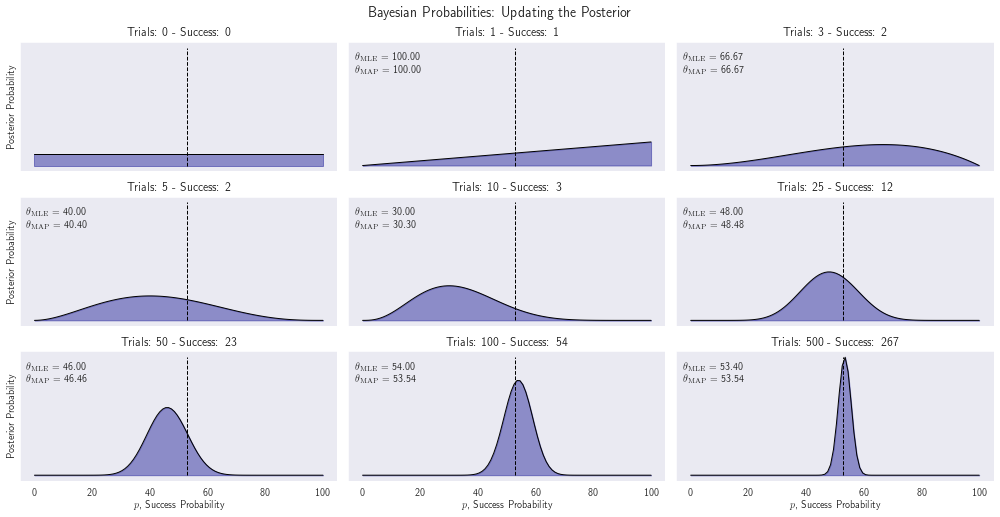

In [9]:
n_days = [0, 1, 3, 5, 10, 25, 50, 100, 500]
# random sample of trading days
# outcomes = sp500_binary.sample(n_days[-1])

# initial 500 trading days
outcomes = sp500_binary.iloc[:n_days[-1]]
p = np.linspace(0, 1, 100)

# uniform (uninformative) prior
a = b = 1

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14, 7), sharex=True)
axes = axes.flatten()
for i, days in enumerate(n_days):
    successes = outcomes.iloc[:days]
    theta_mle = successes.mean()
    up = successes.sum()
    down = days - up
    update = stats.beta.pdf(p, a + up , b + down)
    theta_map = pd.Series(update, index=p).idxmax()
    axes[i] = format_plot(axes, i, p, update, trials=days, success=up, 
                          true_p=sp500_binary.mean(), tmle=theta_mle, tmap=theta_map)

title = 'Bayesian Probabilities: Updating the Posterior'
fig.suptitle(title,  y=1.02, fontsize=14)
fig.tight_layout()